In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Microscale_synthetic_data_generator import DataGenerator
from lmfit import minimize, Parameters, fit_report
from scipy.constants import N_A
from scipy.integrate import solve_ivp

In [88]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 15)
tspan = [1e-10, t_end]
z0 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [90]:
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 15)
tspan = [1e-10, t_end]

A0s1 = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
A0s = []
vals = np.linspace(1, 9, 5)


for x in A0s1:
    for val in vals:
        A0s.append(x*val)
A0s = np.asarray(A0s)
print(len(A0s))
param_dict = {
    'rtot': 1e5,
    'kon': 1e5,
    'koff': 1e-4,
    'k2': 1e2,
    't_eval': t,
    't_span': tspan
}

data_generator = DataGenerator(param_dict)

#data = np.asarray([A1, A2])
#data = data.flatten()

def model_S(t, z, Ainit, rtot, kon, koff, k2):
     k = Ainit*kon
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0/rtot) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def solve_ode_time(params, A0):
     

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']


    z = solve_ivp(model_S, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon, koff, k2))
        
    A10 = z.y[0]/rtot
    A11 = z.y[1]/rtot
    sol = np.asarray([A10, A11])
 
    return sol

def solve_ode_stst(params, A0s):

    rtot = params[f'rtot']
    kon = params[f'kon']
    k2 = params[f'k2']
    koff = params[f'koff']
    A10_stvals = np.zeros_like(A0s)
    A11_stvals = np.zeros_like(A0s)

    for i, A0 in enumerate(A0s):

        z = solve_ivp(model_S, tspan, z0, method='Radau', t_eval=t, args=(A0, rtot, kon, koff, k2))

        A10 = z.y[0]/rtot
        A11 = z.y[1]/rtot
        A10_stst = A10[-1]
        A11_stst = A11[-1]

        A10_stvals[i] = A10_stst
        A11_stvals[i] = A11_stst


    solll = [A10_stvals, A11_stvals]

    return solll

def objective_time(params, data, A0):
    #data = data.flatten()
    ndata = len(data)
    resid = np.zeros_like(data)
    sol = solve_ode_time(params, A0)
    A1 = sol[0]
    A2 = sol[1]
    val = (A1 + A2)
    #sol = sol.flatten()
    for i in range(ndata):
        resid[i] = data[i] - val[i]
    
    return resid.flatten()

def objective_stst(params, data, A0s):

    ndata = len(data)
    resid = np.zeros_like(data)
    sol = solve_ode_stst(params, A0s)
    A10_stst = sol[0]
    A11_stst = sol[1]
    val = (A10_stst + A11_stst)
    for i in range(ndata):
        resid[i] = data[i] - val[i]

    return resid


30


In [92]:
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.15]
fits_list = []

for noise_level in noise_levels:
    sol = data_generator.generate_steady_states(A0s, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)
    result_list = []
    i = 0
    while i < 25:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 500), min=0, max = 800)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=0, max = 1e-1)

        out = minimize(objective_stst, fit_params , args=(data, A0s))
        result_list.append(out)
        print(i)
        i+=1

    fits_list.append(result_list)


In [16]:
fits_list1 = []

for noise_level in noise_levels:
    sol = data_generator.generate_time_series(1e-8, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)

    result_list = []
    i = 0
    while i < 200:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 500), min=0, max = 800)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=1e-6, max = 1e-2)

        out = minimize(objective_time, fit_params, args=(data, 1e-8))
        result_list.append(out)
        print(i)
        i+=1

    fits_list1.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


In [17]:
fits_list2 = []

for noise_level in noise_levels:
    sol = data_generator.generate_time_series(1e-5, 'model S', noise_level)
    A1 = sol[0]/1e5
    A2 = sol[1]/1e5

    data = (A1 + A2)
    data = np.asarray(data)

    result_list = []
    i = 0
    while i < 200:
        fit_params = Parameters()
        fit_params.add(f'rtot', value = np.random.uniform(1e3, 1e7), min=1e3, max = 1e7)
        fit_params.add(f'kon', value = 1e5, min=0, vary=False)
        fit_params.add(f'k2', value = np.random.uniform(0, 200), min=0, max = 200)
        fit_params.add(f'koff', value = np.random.uniform(1e-6, 1e-2),  min=1e-6, max = 1e-2)

        out = minimize(objective_time, fit_params, args=(data, 1e-5))
        result_list.append(out)
        print(i)
        i+=1

    fits_list2.append(result_list)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


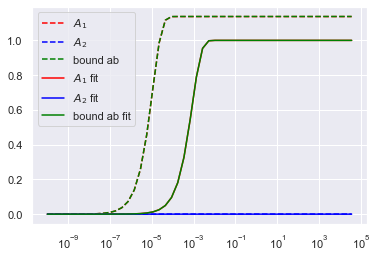

In [18]:
sol = solve_ode_time(out.params, 1e-6)
A1_fit = sol[0]
A2_fit = sol[1]
ab_fit = (A1_fit + A2_fit)
ab = (A1 + A2)
plt.plot(t, A1, '--', label = r'$A_1$', color='red')
plt.plot(t, A2, '--', label = r'$A_2$', color='blue')
plt.plot(t, ab, '--', label = 'bound ab', color='green')
plt.plot(t, A1_fit, label = r'$A_1$' + ' fit', color='red')
plt.plot(t, A2_fit, label = r'$A_2$' + ' fit', color='blue')
plt.plot(t, ab_fit, label = 'bound ab fit', color='green')

plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [73]:
fits_lists = [fits_list, fits_list1, fits_list2]
rtot_vals = np.zeros((3, len(noise_levels)))

for k, fit in enumerate(fits_lists):
    for j, outputs in enumerate(fit):
        holder = np.zeros(200)
        for i, out in enumerate(outputs):
            val = out.chisqr
            holder[i] = val
        arg = np.argmin(holder)
        best_fit = outputs[arg]
        rtot_vals[k][j] = abs(best_fit.params[f'koff'].value - 1e2)/1e2
        print(abs(best_fit.params[f'koff'].value - 1e2)/1e2)

0.9999990000000011
0.999999709223556
0.9999997445165151
0.9999997090967524
0.9999997101031802
0.9999990000001145
0.9999994855449352
0.9999999899997938
0.9999999899999787
0.9999999899998996
0.9999990000039719
0.9999999899999524
0.999999989980544
0.9999999594361675
0.9999999846425471


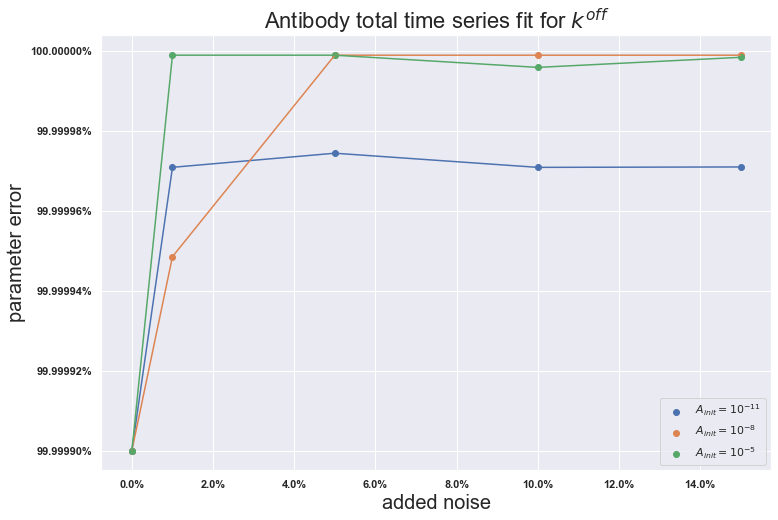

In [74]:
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.size'] = 100
labels = [r'$A_{init}=10^{-11}$', r'$A_{init}=10^{-8}$', r'$A_{init}=10^{-5}$']

ax = plt.subplot()
for i, label in enumerate(labels):
    ax.scatter(noise_levels, rtot_vals[i][:], label = label)
    ax.plot(noise_levels, rtot_vals[i][:])

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.ylabel('parameter error', fontsize = 20 )
plt.title('Antibody total time series fit for ' + r'$k^{off}$', fontsize = 22)
plt.legend()
plt.xlabel('added noise', fontsize = 20)
plt.savefig('/home/heirene/Rotation1-ADCC/ADCC-Project/Figures/synth_data_ab_time_series_koff.png')